# Optimizing Bankruptcy Prediction with K-NN, SMOTE and RandomForest

## Introduction

### Project Background

The possibility of a company facing bankruptcy is a major concern in the economic and financial field. Predicting bankruptcy early can reduce risks and provide stakeholders with valuable information to make informed decisions. The project aims to leverage machine learning techniques to predict the probability of bankruptcy based on financial metrics. We particularly address the challenges posed by unbalanced datasets, which are common in bankruptcy prediction scenarios where the number of solvent companies far exceeds the number of insolvent companies.

### Main Question

Can we accurately predict the likelihood of a company facing bankruptcy by applying *Synthetic Minority Over-sampling Technique (SMOTE)* for data balancing, *RandomForest* for factors selection and *K-NN* for classification? (That is, we are trying to build a model that can predict whether a company will go bankrupt)

### Dataset Description

The dataset chosen for this project is from Kaggle (https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/data) , which comprises various financial indicators of American public companies listed on the New York Stock Exchange and NASDAQ over a period. It includes features such as current assets, market value, inventory, depreciation and amortization etc. The target variable is binary, indicating whether a company went bankrupt or remained solvent within the time frame studied.

## Preliminary Exploratory Data Analysis

### Read the dataset from internet

First, we install and load the ***tidyverse*** and ***tidymodel*** libraries we're going to use:

In [24]:
# install.packages("tidyverse")
# install.packages("tidymodels")
library(tidyverse)
library(tidymodels)

Then we download the dataset from our github repository (https://raw.githubusercontent.com/4ugenstern/DSCI-100-GroupProject/main/american_bankruptcy.csv) and split the dataset to training and testing sets:

In [25]:
url <- "https://raw.githubusercontent.com/4ugenstern/DSCI-100-GroupProject/main/american_bankruptcy.csv"
download.file(url, "data.csv")

raw_data <- read_csv("data.csv") |>
    mutate(status_label = as_factor(status_label))

cat("\ntable 1:")
head(raw_data)

set.seed(1000)

data_split <- initial_split(raw_data, prop = 0.5, strata = status_label)
bank_train <- training(data_split)
bank_test <- testing(data_split)

Rows: 78682 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): company_name, status_label
dbl (19): year, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



table 1:

company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,⋯,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,⋯,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,⋯,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,⋯,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,⋯,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,⋯,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
C_1,alive,2004,474.542,598.172,27.950,61.774,255.477,15.453,127.121,⋯,747.848,732.230,227.159,33.824,149.676,160.025,142.450,747.848,417.486,686.074


### Clean and wrangle the dataset

As we can see from the dataset above, there is only one single observation in each row, only one single variable in each column (X1 to X18 have their own names, for convenience we will convert them into readable labels later), and each value is a single cell. Therefore, we claim that this dataset is already in the tidy format. The only thing we're going to do is to add another column with the status in numeric format, called "status_label_num".

In [26]:
bank_train <- bank_train |>
    mutate(status_label_num = ifelse(status_label == "alive", 1, 0)) # 1: alive, 0: failed

bank_test <- bank_test |>
    mutate(status_label_num = ifelse(status_label == "alive", 1, 0)) # 1: alive, 0: failed

### Data Observation

We can observe the training set by counting first:

In [27]:
print(paste("# of Rows:", nrow(bank_train)))
print(paste("# of Columns:", ncol(bank_train)))

[1] "# of Rows: 39341"
[1] "# of Columns: 22"


As we can see, there are 39341 rows and 22 columns in the training set.

Then, we summarize some statistics for the training set:

In [28]:
cat("\ntable 2:")
bank_train |>
    pivot_longer(X1:X18, names_to = "Factors", values_to = "Values") |>
    group_by(Factors) |>
    summarize("# of Missing" = sum(is.na(Values)),
             "# of Unique" = n_distinct(Values, na.rm = TRUE),
             "min" = min(Values, na.rm = TRUE),
             "max" = max(Values, na.rm = TRUE),
             "mean" = mean(Values, na.rm = TRUE),
             "Standard Deviation" = sd(Values, na.rm = TRUE),
             "percentile_25" = quantile(Values, 0.25, na.rm = TRUE),
             "percentile_75" = quantile(Values, 0.75, na.rm = TRUE)) |>
    mutate(Factors_numeric = as.numeric(gsub("X", "", Factors))) |>
    arrange(Factors_numeric) |>
    select(-Factors_numeric)


table 2:

Factors,# of Missing,# of Unique,min,max,mean,Standard Deviation,percentile_25,percentile_75
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,0,35447,-7.7600,169662.0,905.3531,4105.2285,18.7630,433.642
X2,0,35247,-366.6450,374623.0,1632.1516,9345.5055,16.8420,648.194
X3,0,22275,0.0000,22308.0,124.0491,651.5121,1.1920,48.683
X4,0,33176,-21913.0000,81730.0,390.6693,2110.3948,-0.8570,140.406
X5,0,22411,0.0000,62567.0,208.1382,1127.0417,0.0020,77.270
X6,0,31906,-98696.0000,53394.0,133.5935,1304.2775,-7.5370,40.078
X7,0,28452,-0.0060,65812.0,294.7543,1392.5724,3.2260,132.113
X8,0,39070,0.0003,790050.1,3567.0112,19670.1594,34.8908,1254.412
X9,0,36088,-1964.9990,511729.0,2426.1500,12562.5706,27.1700,1065.731


### Target Column Distribution

We use *pie()* function to make a pie chart of our target column:

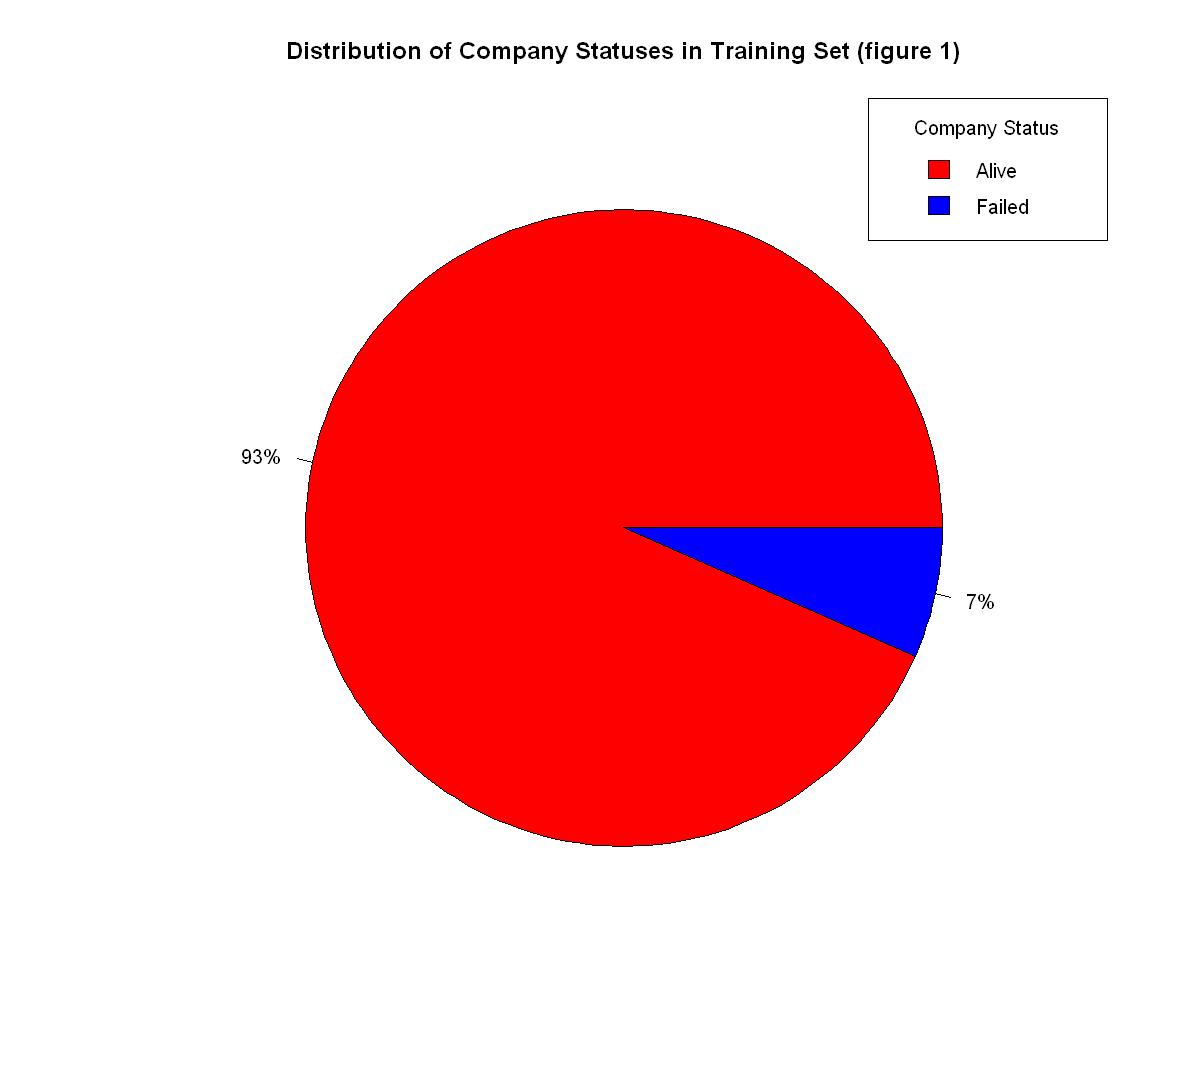

In [29]:
alive <- filter(bank_train, status_label == "alive")
total_number <- nrow(bank_train)
alive_number <- nrow(alive)
failed_number <- total_number - alive_number

pie_data <- c(alive_number, failed_number)
pie_labels <- c("Alive", "Failed")
status_label <- c("Alive", "Failed")
slice_colors <- c("red", "blue")

pie(pie_data, labels = percent(pie_data / sum(pie_data)), col = slice_colors, main = "Distribution of Company Statuses in Training Set (figure 1)")

legend("topright",
    legend = status_label,
    fill = slice_colors,
    title = "Company Status")

The "Alive Ratio" is approximately 92% and the "Failed Ratio" is approximately 7%, which means that 93% of the samples belongs to the "Alive" class (haven't gone bankrupt) and 7% of the samples belongs to the "Failed" class (have gone bankrupt).

We could also claim that this is a highly imbalanced dataset and the model may be biased and cause problems when identifying minority groups. To address the issue, we will use some class balancing techniques like *Synthetic Minority Over-sampling Technique (SMOTE)* to oversample the minority class (Failed).

### Outliers

First, we convert the dataframe to a longer version:

In [30]:
bank_long <- bank_train |>
    select(-c(company_name, status_label, year, status_label_num)) |>
    pivot_longer(cols = everything(), names_to = "Variable", values_to = "Value")

Then we can draw the boxplot for each factor:

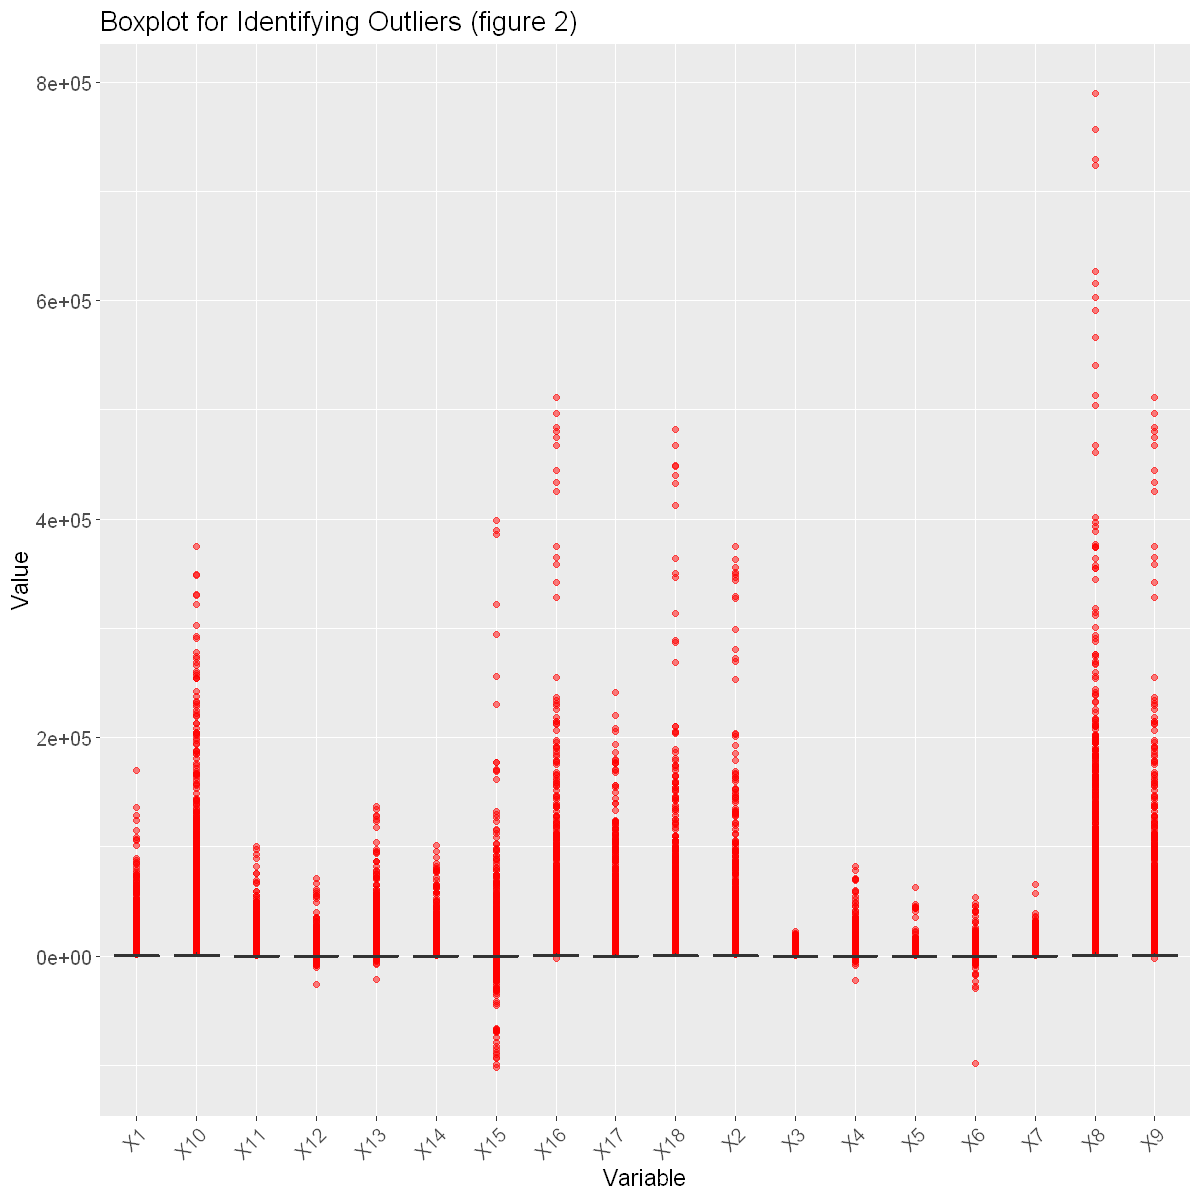

In [31]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(bank_long, aes(x = Variable, y = Value)) + 
    geom_boxplot(alpha = 0.5, outlier.colour = "red") +
    theme(axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
          axis.text.y = element_text(size = 12),
          axis.title.x = element_text(size = 14),
          axis.title.y = element_text(size = 14),
          plot.title = element_text(size = 16)) + 
    labs(title = "Boxplot for Identifying Outliers (figure 2)", x = "Variable", y = "Value")

### Correlation Matrix

First, we install and load the ***ggplot2*** and ***reshape2*** libraries to plot the graph:

In [32]:
# install.packages("ggplot2")
# install.packages("reshape2")
library(ggplot2)
library(reshape2)

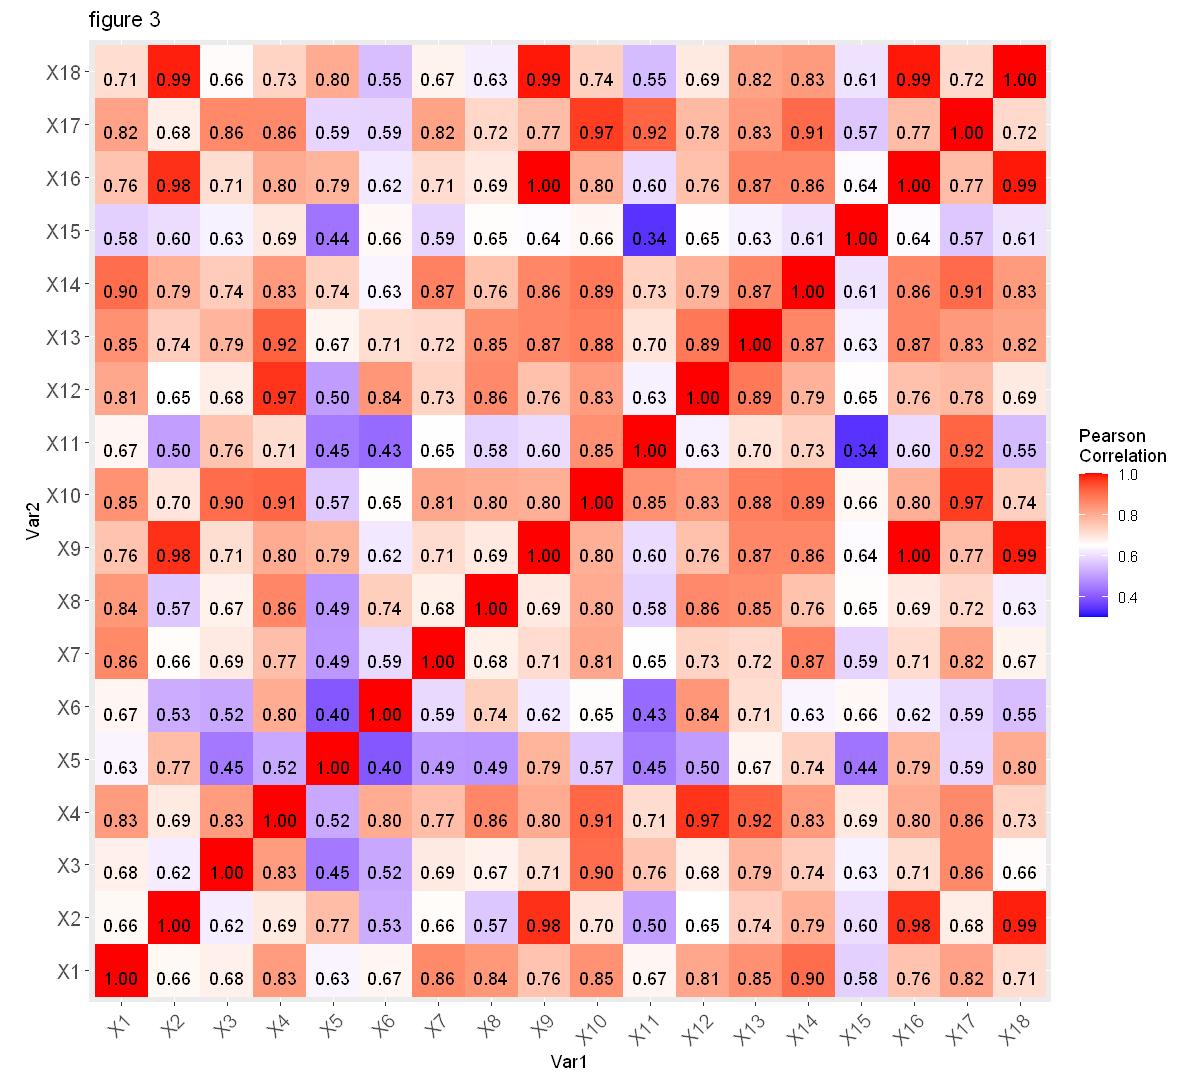

In [33]:
bank_train_select <- select(bank_train, -c(company_name, status_label, year, status_label_num))
cor_bank_train <- cor(bank_train_select)

long_cor <- melt(cor_bank_train)

options(repr.plot.width = 10, repr.plot.height = 9)

ggplot(data = long_cor, aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() +
    geom_text(aes(label = sprintf("%.2f", value)), vjust = 1) +
    scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                         midpoint = 0.65, limit = c(0.3,1), space = "Lab",
                         name="Pearson\nCorrelation") +
    labs(title = "figure 3") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1),
          axis.text.y = element_text(size = 12)) +
    coord_fixed()

As we can see from the Correlation Matrix,  
- *X2*, *X9*, *X16* and *X18* are highly correlated to each other;
- *X4* and *X12* are highly correlated to each other;
- *X10*, *X11* and *X17* are highly correlated to each other.
- *X9 = X16*
- *X16 - X2 = X13*
- *X14 - X12 = X3*

## Methods

- Apply ***SMOTE*** to oversample the failed class.   
  The reason why we choose to use ***SMOTE*** is it helps address class imbalance by generating synthetic examples from the minority class, thereby providing a more balanced dataset. This improved balance can enhance the performance of machine learning models by preventing them from being overly biased towards the majority class, leading to better generalization and accuracy in predicting minority class outcomes.
- Apply ***RandomForest*** to find out the most important factors.
  The reason why we choose to use ***RandomForest*** is it is an effective ensemble learning method for binary classification that utilizes multiple decision trees to make predictions. By aggregating the decisions from various trees, it reduces overfitting and improves accuracy. Importantly, Random Forest can also rank the importance of different factors (features) in the classification task, allowing us to identify and focus on the most influential variables for predictive modeling.
- Build the main models with our training data.
- Use the testing data to test the accuracy of the model and enhance the model.

### Factor Choose

First, we install and load the ***smotefamily***  library:

In [34]:
# install.packages("smotefamily")
library(smotefamily)

Then, we apply *SMOTE* technique to oversample the failed class:

In [35]:
set.seed(1000)

data_no_label <- bank_train |>
    select(X1:X18)
data_label_only <- bank_train |>
    select(status_label)

data_smote <- SMOTE(data_no_label, data_label_only, 5, dup_size = 10)$data

data_smote <- data_smote |>
    rename(status_label = class) |>
    mutate(status_label_num = ifelse(status_label == "alive", 1, 0)) # 1: alive, 0: failed

cat("\ntable 3:")
head(data_smote)
cat("\ntable 4:")
tail(data_smote)


table 3:

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,status_label,status_label_num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
69.263,7.549,1.701,-33.247,0.395,-35.778,0.953,55.9810,8.754,90.180,90.000,-34.948,1.205,8.132,-92.036,8.754,98.277,42.001,failed,0
34.674,53.724,63.072,143.240,0.000,29.894,28.650,463.1054,211.061,861.055,340.255,80.168,157.337,69.773,69.804,211.061,463.664,67.821,failed,0
2703.000,4839.000,284.000,-250.000,607.000,-764.000,1103.000,176.2613,6022.000,4678.000,1363.000,-534.000,1183.000,2150.000,1405.000,6022.000,7028.000,6272.000,failed,0
56.978,48.433,3.002,25.528,18.105,14.652,17.878,417.5308,103.194,104.291,3.000,22.526,54.761,5.011,-24.644,103.194,8.011,77.666,failed,0
1965.000,5846.000,401.000,897.000,677.000,65.000,540.000,3764.3000,7483.000,10805.000,4918.000,496.000,1637.000,1375.000,-1605.000,7483.000,8485.000,6586.000,failed,0
40.839,70.700,1.173,4.977,18.414,1.211,17.128,33.5204,91.658,65.591,0.000,3.804,20.958,33.081,-13.369,91.658,33.167,86.681,failed,0



table 4:

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,status_label,status_label_num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
10566.000,31288.000,1200.000,6545.000,4515.000,4688.000,4434.000,31242.9625,39004.000,28278.000,8497.000,5345.000,7716.000,5513.000,5400.000,39004.000,17882.000,32459.000,alive,1
2270.500,1216.700,250.900,524.000,517.500,-308.600,1148.000,2944.0231,2542.300,10190.200,5173.600,273.100,1325.600,1062.400,-1418.800,2542.300,7271.000,2018.300,alive,1
2340.600,1833.200,354.200,758.100,490.400,-296.200,1156.000,2850.9981,3775.900,10252.400,5440.600,403.900,1942.700,1091.800,-1291.700,3775.900,7392.400,3017.800,alive,1
973.800,1185.500,44.000,439.300,360.600,175.200,259.900,5314.7873,2118.300,2015.900,1215.000,395.300,932.800,531.300,-5.800,2118.300,1997.400,1679.000,alive,1
233.211,43.338,14.094,45.615,3.376,25.261,22.846,756.4827,104.223,1099.101,184.666,31.521,60.885,28.197,28.095,104.223,225.887,58.608,alive,1
135.207,66.527,65.330,69.171,2.013,-20.401,27.217,412.6241,161.884,1736.110,694.035,3.841,95.357,82.010,135.941,161.884,776.697,92.713,alive,1


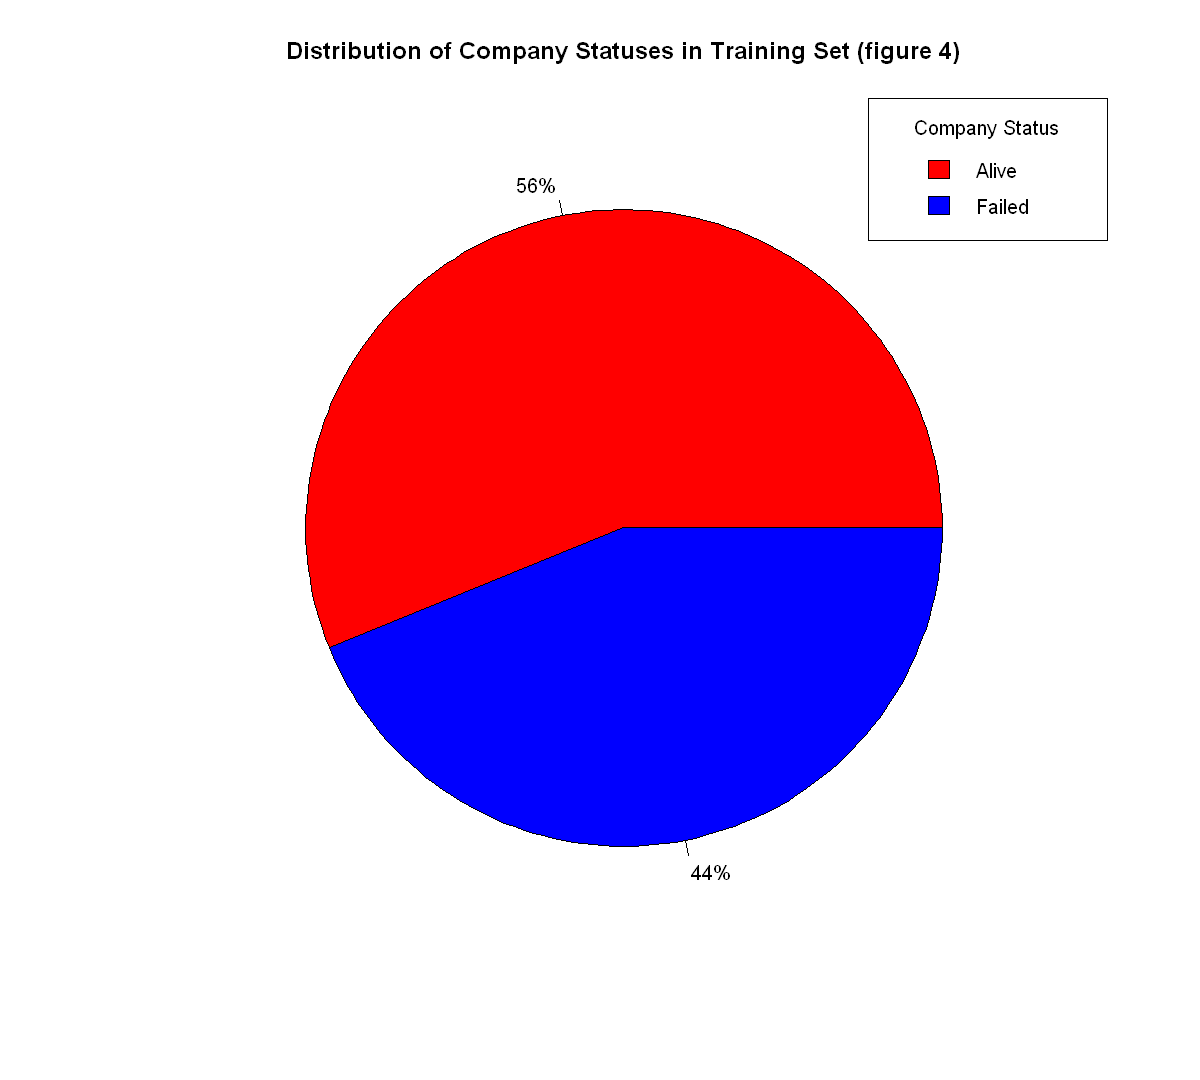

In [36]:
alive <- filter(data_smote, status_label == "alive")
total_number <- nrow(data_smote)
alive_number <- nrow(alive)
failed_number <- total_number - alive_number

pie_data <- c(alive_number, failed_number)
pie_labels <- c("Alive", "Failed")
status_label <- c("Alive", "Failed")
slice_colors <- c("red", "blue")

pie(pie_data, labels = percent(pie_data / sum(pie_data)), col = slice_colors, main = "Distribution of Company Statuses in Training Set (figure 4)")

legend("topright",
    legend = status_label,
    fill = slice_colors,
    title = "Company Status")

After oversample the data, we install and load the ***randomForest*** library, build the *randomForest* model:

In [37]:
# install.packages("randomForest")
library(randomForest)

rf_model <- randomForest(as_factor(status_label_num) ~ . - status_label, data = data_smote, ntree = 500, mtry = sqrt(ncol(data_smote)-2))

Then apply the *RandomForest* model to the smoted data and get the importance for each variables:

In [38]:
importance_matrix <- importance(rf_model)

importance_df <- as.data.frame(importance_matrix)

sorted_importance_df <- importance_df |>
    arrange(-MeanDecreaseGini)

cat("\ntable 5:")
slice_head(sorted_importance_df, n = 10)
print(rf_model)


table 5:

,MeanDecreaseGini
,<dbl>
X11,2711.548
X8,2506.845
X5,2288.952
X15,2220.951
X6,2174.314
X3,1884.540
X2,1688.331
X1,1677.201
X17,1673.931



Call:
 randomForest(formula = as_factor(status_label_num) ~ . - status_label,      data = data_smote, ntree = 500, mtry = sqrt(ncol(data_smote) -          2)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 4.56%
Confusion matrix:
      0     1 class.error
0 27404  1284  0.04475739
1  1698 35035  0.04622546


According to the observation we have in Correlation Matrix, we will only consider one or two from *X2*, *X9*, *X13*, *X16*, *X18*; one or two from *X3*, *X4*, *X12*, *X14*; one or two from *X10*, *X11*, *X17 since they're highly correlated to each other, and the top 10 MeanDecreaseGini generated by *RandomForest*, the predictors we will choose are as follow:  
- *X1 (Current assets)*,
- *X3 (Depreciation and amortization)*,
- *X5 (Inventory)*,
- *X6 (Net Income)*
- *X7 (Total Receivables)*,
- *X8 (Market Value)*,
- *X11 (Total Long term debt)*
- *X13 (Gross Profit)*,
- *X15 (Retained Earnings)*
- *X17 (Total Liabilities)*.

### Visialization and Results

We will directly use the *Accuracy*, *Precision* and *Recall* to show how good is our model. Also, we may choose to use a *Receiver Operating Characteristic (ROC) curve* and the *Area Under the Curve (AUC) metric* to visualize our model, since our classification is a binary classification.

Here we're going to apply all the three models we have learned in the course: the _K-NN classification_, _K-NN regression_ and _linear regression_.

First is the *K-NN regression*, we create the workflow and choose the best *K* value first.

In [39]:
bank_kreg_recipe <- recipe(status_label_num ~ X1 + X3 + X5 + X6 + X7 + X8 + X11 + X13 + X15 + X17, data = data_smote) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

bank_kreg_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

bank_kreg_vfold <- vfold_cv(data_smote, v = 5, strata = status_label_num)

bank_wkflw <- workflow() |>
    add_recipe(bank_kreg_recipe) |>
    add_model(bank_kreg_spec)

bank_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 



table 6:

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.2823024,5,0.001066379,Preprocessor1_Model01
2,rmse,standard,0.2790805,5,0.000692879,Preprocessor1_Model02
3,rmse,standard,0.2852039,5,0.001165123,Preprocessor1_Model03
4,rmse,standard,0.2924308,5,0.001596168,Preprocessor1_Model04
5,rmse,standard,0.2987160,5,0.001847808,Preprocessor1_Model05
6,rmse,standard,0.3044802,5,0.001900713,Preprocessor1_Model06
7,rmse,standard,0.3097315,5,0.001894784,Preprocessor1_Model07
8,rmse,standard,0.3148747,5,0.001788014,Preprocessor1_Model08
9,rmse,standard,0.3196057,5,0.001535685,Preprocessor1_Model09



figure 5:

[1] 2

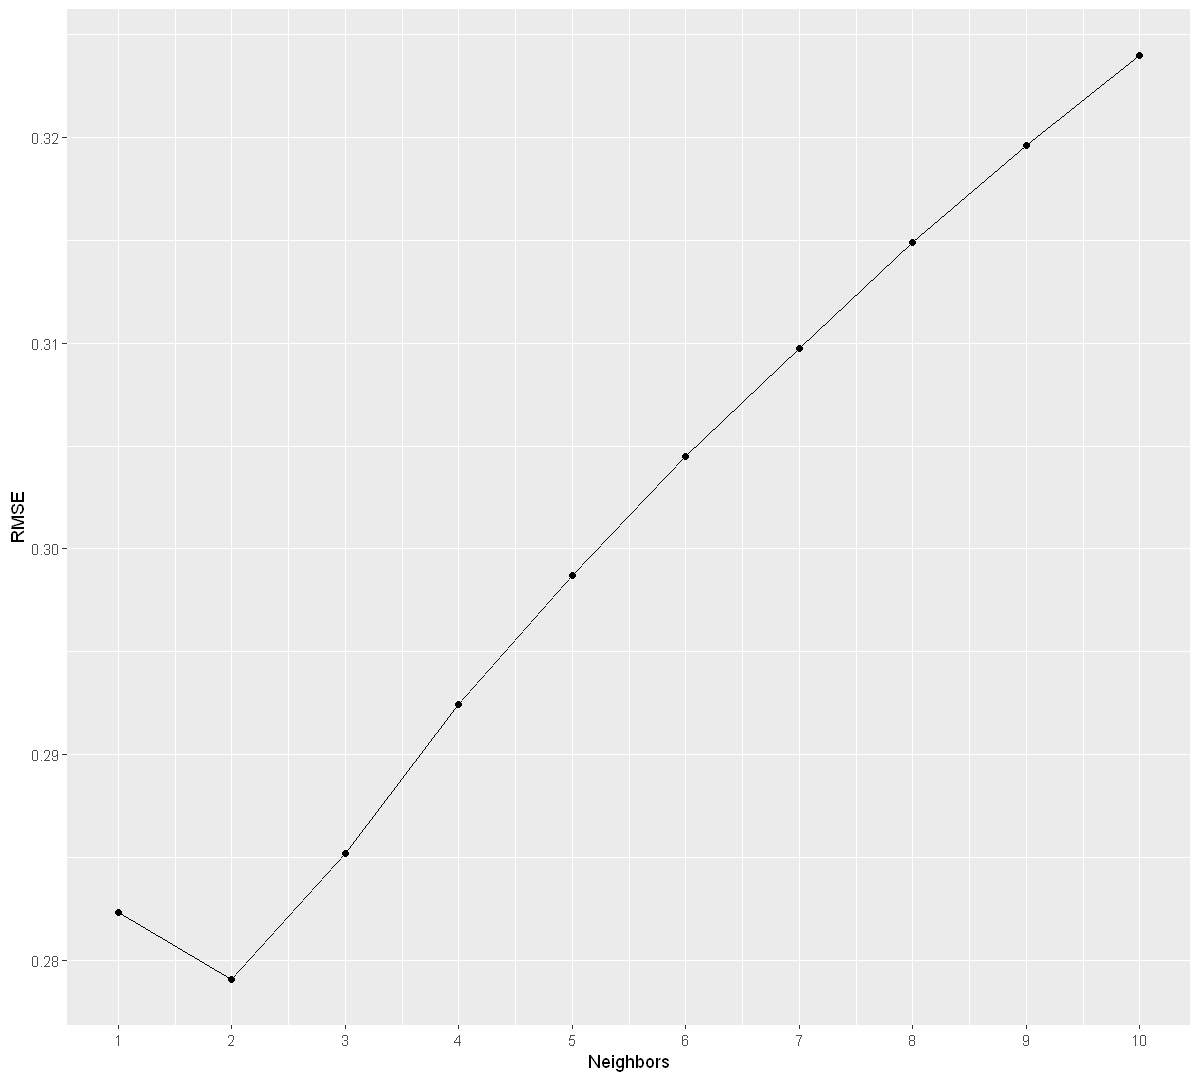

In [40]:
kreg_gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

bank_reg_results <- bank_wkflw |>
    tune_grid(resamples = bank_kreg_vfold, grid = kreg_gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

cat("\ntable 6:")
bank_reg_results

rmse_vs_k <- ggplot(bank_reg_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = seq(0, 10, by = 1)) +
    labs(x = "Neighbors", y = "RMSE")

cat("\nfigure 5:")
rmse_vs_k

k_min <- bank_reg_results |>
    slice_min(mean, n = 1) |>
    pull(neighbors)

k_min

Then we perform the model on the test dataset.

In [41]:
bank_kreg_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

bank_kreg_fit_best<- workflow() |>
    add_recipe(bank_kreg_recipe) |>
    add_model(bank_kreg_spec_best) |>
    fit(data = data_smote)

kreg_predictions <- bank_kreg_fit_best |>
    predict(bank_test) |>
    bind_cols(bank_test) |>
    mutate(predicted_class = ifelse(.pred > 0.5, 1, 0)) |>
    mutate(predicted_class = as_factor(predicted_class), 
           status_label_num = as_factor(status_label_num))

And finally we check the the pereformance of this model.


table 7:

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.3601202
rsq,standard,0.1104639
mae,standard,0.1614855


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7869144


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.1904966


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6799387


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.2393861



figure 6:

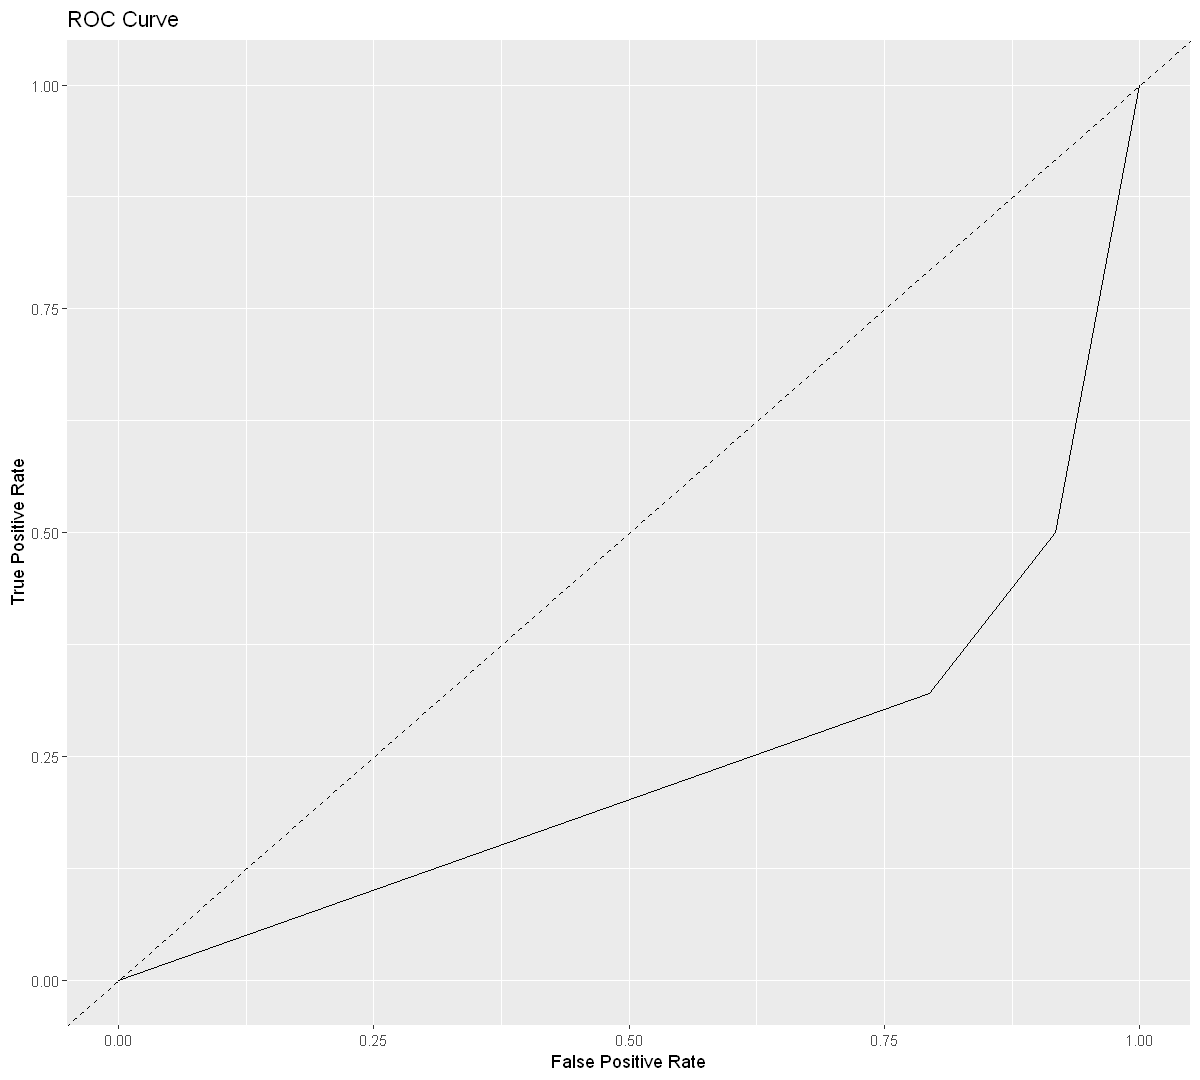

In [42]:
bank_summary_kreg <- bank_kreg_fit_best |>
    predict(bank_test) |>
    bind_cols(bank_test) |>
    metrics(truth = status_label_num, estimate = .pred)

acc_result_kreg <- accuracy(kreg_predictions, truth = status_label_num, estimate = predicted_class)

precision_result_kreg <- precision(kreg_predictions, truth = status_label_num, estimate = predicted_class)

recall_result_kreg <- recall(kreg_predictions, truth = status_label_num, estimate = predicted_class)

auc_result_kreg <- roc_auc(kreg_predictions, truth = status_label_num, .pred)

roc_data_kreg <- roc_curve(kreg_predictions, truth = status_label_num, .pred)

roc_plot_kreg <- ggplot(roc_data_kreg, aes(x = 1 - specificity, y = sensitivity)) +
    geom_line() +
    geom_abline(linetype = "dashed") +
    labs(x = "False Positive Rate", y = "True Positive Rate", title = "ROC Curve")

cat("\ntable 7:")
bank_summary_kreg
acc_result_kreg
precision_result_kreg
recall_result_kreg
auc_result_kreg
cat("\nfigure 6:")
roc_plot_kreg

As we can see from the precision and ROC, this model is not good enough. The main problem could be that regression will not have a good result for a binary classification.

Secondly, we build and apply the *linear regression* model to the test dataset.

In [43]:
bankl_lreg_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

bank_lreg_recipe <- recipe(status_label_num ~ X1 + X3 + X5 + X6 + X7 + X8 + X11 + X13 + X15 + X17, data = data_smote)


bank_lreg_fit <- workflow() |>
    add_recipe(bank_lreg_recipe) |>
    add_model(bankl_lreg_spec) |>
    fit(data = data_smote)

bank_lreg_fit

bank_lreg_predictions <- predict(bank_lreg_fit, bank_test) |>
    bind_cols(bank_test) |>
    mutate(predicted_class = ifelse(.pred > 0.5, 1, 0)) |>
    mutate(predicted_class = as_factor(predicted_class), 
           status_label_num = as_factor(status_label_num))

bank_rmse <- bank_lreg_fit |>
    predict(data_smote) |>
    bind_cols(data_smote) |>
    metrics(truth = status_label_num, estimate = .pred) |>
    filter(.metric == 'rmse') |>
    select(.estimate) |>
    pull()

bank_rmspe <- bank_lreg_fit |>
    predict(bank_test) |>
    bind_cols(bank_test) |>
    metrics(truth = status_label_num, estimate = .pred) |>
    filter(.metric == 'rmse') |>
    select(.estimate) |>
    pull()

coeffs <- bank_lreg_fit |>
    extract_fit_parsnip() |>
    tidy()

bank_rmse
bank_rmspe
cat("\ntable 8:")
coeffs

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)           X1           X3           X5           X6           X7  
  5.551e-01   -6.720e-06   -8.421e-06    2.895e-05    1.837e-05    4.757e-05  
         X8          X11          X13          X15          X17  
  3.111e-06    1.059e-05    8.008e-07   -1.030e-07   -1.281e-05  


[1] 0.492577

[1] 0.4474993


table 8:

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.550987e-01,2.005270e-03,276.8198719,0.000000e+00
X1,-6.719511e-06,1.827220e-06,-3.6774510,2.357649e-04
X3,-8.420991e-06,8.705523e-06,-0.9673160,3.333897e-01
X5,2.895341e-05,3.409410e-06,8.4922069,2.069305e-17
X6,1.836851e-05,2.954874e-06,6.2163441,5.119325e-10
X7,4.756899e-05,4.186639e-06,11.3620949,6.888644e-30
X8,3.111299e-06,3.004041e-07,10.3570460,4.065755e-25
X11,1.058645e-05,2.240032e-06,4.7260277,2.294298e-06
X13,8.007539e-07,1.805296e-06,0.4435581,6.573636e-01


Then check the performance of it.


table 9:

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9259043


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
sens,binary,0.01990812


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.1277641


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.3735607



figure 7:

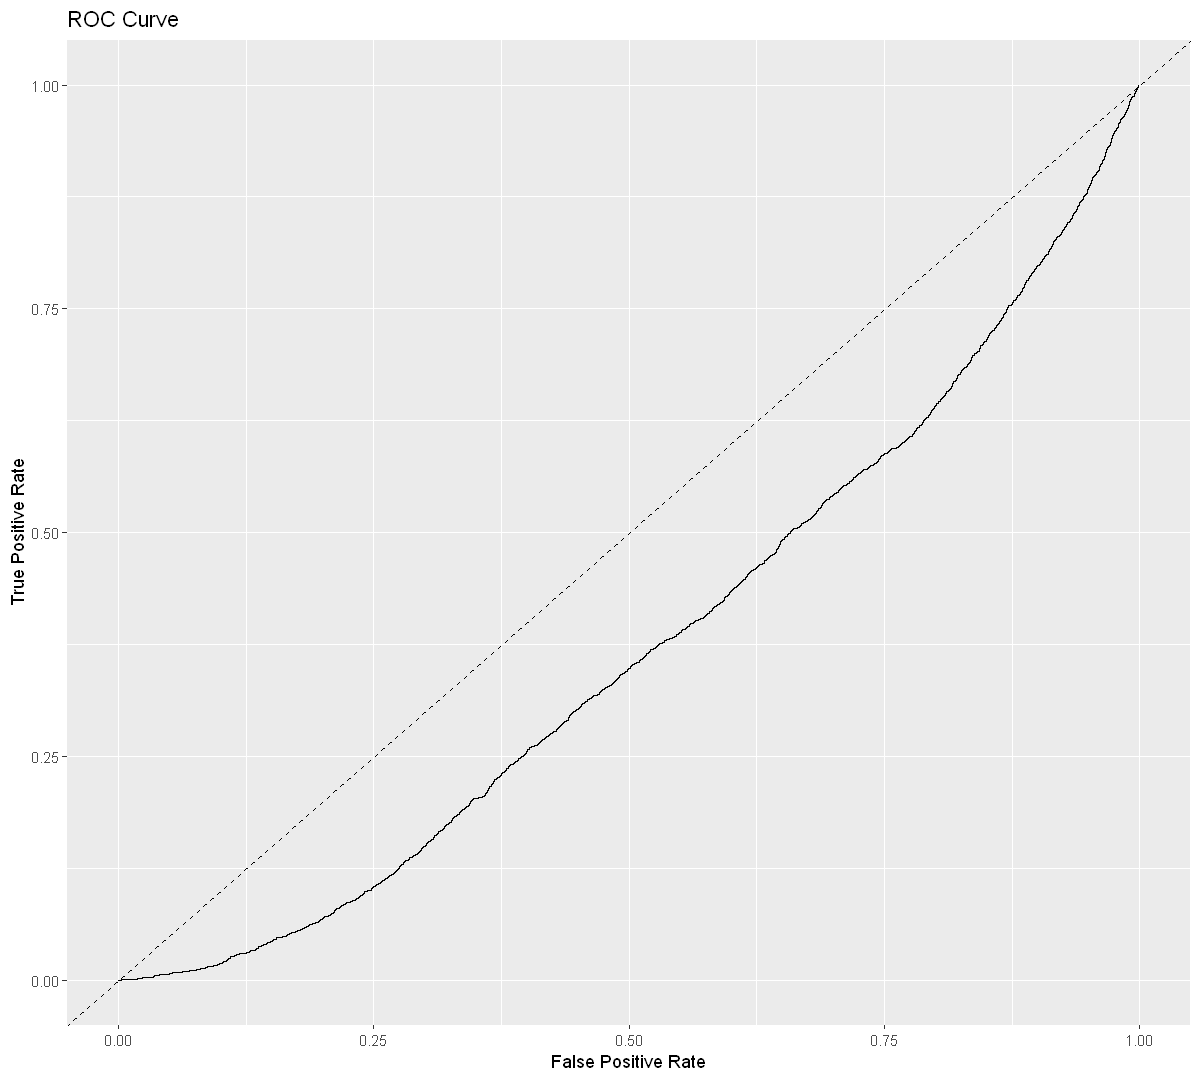

In [44]:
accuracy_result_lreg <- accuracy(bank_lreg_predictions, truth = status_label_num, estimate = predicted_class)

recall_result_lreg <- sens(bank_lreg_predictions, truth = status_label_num, estimate = predicted_class)

precision_result_lreg <- precision(bank_lreg_predictions, truth = status_label_num, estimate = predicted_class)

auc_result_lreg <- roc_auc(bank_lreg_predictions, truth = status_label_num, .pred)

roc_data_lreg <- roc_curve(bank_lreg_predictions, truth = status_label_num, .pred)

roc_plot_lreg <- ggplot(roc_data_lreg, aes(x = 1 - specificity, y = sensitivity)) +
    geom_line() +
    geom_abline(linetype = "dashed") +
    labs(x = "False Positive Rate", y = "True Positive Rate", title = "ROC Curve")

cat("\ntable 9:")
accuracy_result_lreg
recall_result_lreg
precision_result_lreg
auc_result_lreg
cat("\nfigure 7:")
roc_plot_lreg

We got the same problem here, the model is not good enough for binary classification.

Lastly, the *K-NN classification* model. We find the best *K* value first.


table 10:

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9201328,5,0.001468026,Preprocessor1_Model01
2,accuracy,binary,0.9201328,5,0.001468026,Preprocessor1_Model02
3,accuracy,binary,0.8939027,5,0.002378592,Preprocessor1_Model03
4,accuracy,binary,0.8939027,5,0.002378592,Preprocessor1_Model04
5,accuracy,binary,0.8778834,5,0.002023027,Preprocessor1_Model05
6,accuracy,binary,0.8778834,5,0.002023027,Preprocessor1_Model06
7,accuracy,binary,0.8639735,5,0.001863828,Preprocessor1_Model07
8,accuracy,binary,0.8639735,5,0.001863828,Preprocessor1_Model08
9,accuracy,binary,0.8540225,5,0.001668058,Preprocessor1_Model09



figure 8:

[1] 1

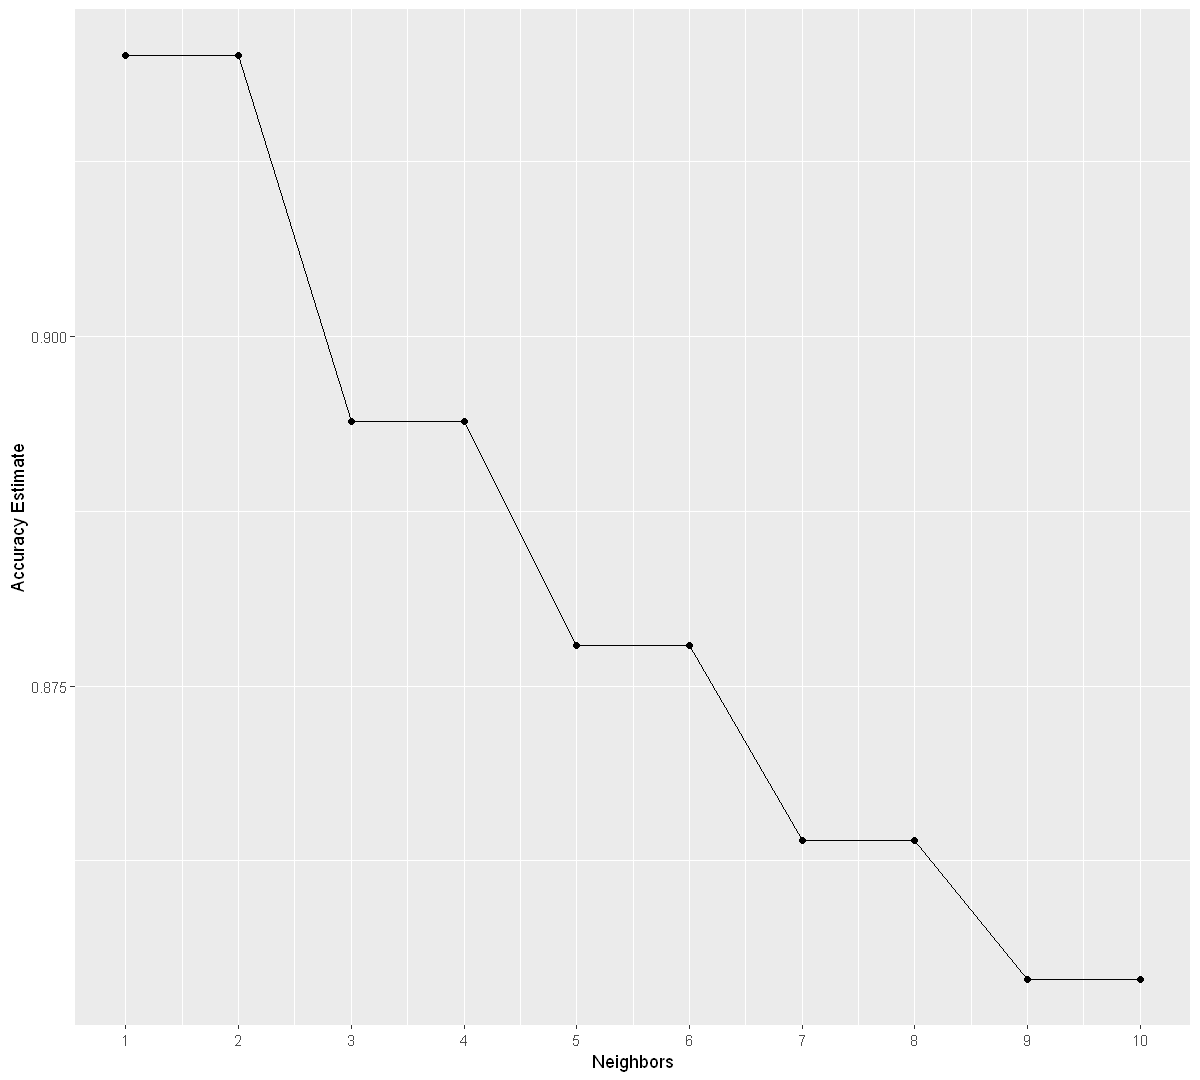

In [45]:
bank_spec_kclass <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

bank_recipe_kclass <- recipe(status_label ~ X1 + X3 + X5 + X6 + X7 + X8 + X11 + X13 + X15 + X17, data = data_smote) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

bank_vfold_kclass <- vfold_cv(data_smote, v = 5, strata = status_label)

bank_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

bank_results_kclass <- workflow() |>
    add_recipe(bank_recipe_kclass) |>
    add_model(bank_spec_kclass) |>
    tune_grid(resamples = bank_vfold_kclass, grid = bank_vals) |>
    collect_metrics()

accuracies <- bank_results_kclass |>
    filter(.metric == "accuracy")

cat("\ntable 10:")
accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = seq(0, 10, by = 1)) +
    labs(x = "Neighbors", y = "Accuracy Estimate")

cat("\nfigure 8:")
accuracy_vs_k

best_k <- accuracies |>
    arrange(-mean)|>
    head(1)|>
    pull(neighbors)

best_k

Then we apply the model on the test dataset and see the performance.

In [47]:
bank_spec_best_kclass <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

bank_fit_best_kclass <- workflow() |>
    add_recipe(bank_recipe_kclass) |>
    add_model(bank_spec_best_kclass) |>
    fit(data = data_smote)

bank_test_predictions_kclass <- predict(bank_fit_best_kclass, bank_test) |>
    bind_cols(bank_test)

cat("table 11:")
bank_test_predictions_kclass |>
    metrics(truth = status_label, estimate = .pred_class) |>
    filter(.metric == "accuracy")

precision(bank_test_predictions_kclass, truth = status_label, estimate = .pred_class, event_level = "second")
recall(bank_test_predictions_kclass, truth = status_label, estimate = .pred_class, event_level = "second")
conf_mat(bank_test_predictions_kclass, truth = status_label, estimate = .pred_class)

table 11:

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8642892


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2593965


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5627871


          Truth
Prediction alive failed
    alive  32532   1142
    failed  4197   1470

Still, the result is not good enough.

## Discussion

### Summarization

Basically, three models were successfully built to predict whether a listed company will go bankrupt. The accuracy and recall is fairly acceptable, and all the models work well. However, these models are defenitely not good enough, since we're going to predict whether a bank will go bankrupt or not, we expect a higher precision. We assume thr main problem could be the *SMOTE* technique we used. Since the dataset comes from the real company in America, and there are lots of outliers in it, therefore, it could be hard to oversample the minority without affect the relationship between the factors. Also, two regression models cannot handle a binary classificaiton well and the classification model is moderately sensitive to the imbalance. Both of them lead to the low precision of the models.

### Improvement

If we have time, we want to apply *Logistic Regression* model to handle this classification. Since it is specifically tailored for binary classification as it models the probability of class memberships and provides interpretable outputs, unlike linear regression which assumes a linear relationship and K-NN which relies on proximity to other data points without direct probability estimation. Additionally, logistic regression handles high-dimensional spaces more efficiently than K-NN classification, which often suffers from the curse of dimensionality (9 in our cases), leading to degraded performance in such scenarios. 

### Impact of the findings

These findings can be beneficial to potential business owners who wish to know how successful other businesses in the same fields as theirs are succeeding. They can also be useful to current business owners as this model can help predicting whether their business is headed towards bankruptcy or not. Also, it's valuable to investors, who could leverage these insights to make more informed decisions about their portfolios, potentially avoiding substantial losses by steering clear of companies at risk of bankruptcy. 

### Future Questions

- We may have to include the real-time data to analyse.
- Modify the model so that it could work on a specific industy with unique values or factors, so that we could make more accurate predictions.
- Change the model or apply novel machine learning innovation to improve the model.

### References

[1] X27, U. (2023). American companies bankruptcy prediction dataset [Data set]. Kaggle. Retrieved April 15, 2024, from https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/data   
[2] Timbers, T., Campbell, T., & Lee, M. (2023). Data science: A first introduction. Retrieved from https://datasciencebook.ca/   
[3] Liu, M (2024). Introduction to Data Science (DSCI 100). Department of Statistics. University of British Columbia.